<a href="https://colab.research.google.com/github/data-better/forecasting_class/blob/main/R_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 구글 Colab

* 구글 id가 있어야 이용 가능, 구글 drive 이용
* 텍스트와 코드로 구성 
  - 텍스트 작성 : 마크다운
  - 코드 수행 : Crtl+Enter, Shift+Enter, Alt+Enter 
* 크롬 브라우저에서 Python과 R을 실행 : R은 임시
  - 설치 필요하지 않음
  - GPU 무료 액세스
* Pyhon 기반 : https://colab.research.google.com/
* R : https://colab.research.google.com/notebook#create=true&language=r

In [12]:
library()

## 1. 데이터 읽기
  * KOSIS 또는 ECOS에서 데이터를 csv 형태로 내려받은 후
  * 설명한 내용을 제거하고, 셀형식을 "," 없는 숫자로 전환하여 직사각형 형태로 저장
  * 여기서는 1970년- 2020년 분기 제조업 GDP, 서비스업 GDP, GDP 입니다.
  * magrittr 패키지를 니용하면 %>% 의 파이프를 쓸 수 있습니다.(colab에 이미 설치)

In [11]:
# GITHUB의 data 폴더의 csv를 지정하여 읽어옴

#  제조업 GDP, 서비스업 GDP, GDP  원계열
url_o = "https://raw.githubusercontent.com/data-better/forecasting_class/main/data/gdp_21.csv"
gdp_ts = url_o %>% read.csv() %>% ts(, start=1970, frequency=4)
gdp_ts %>% head()

,gdp_m,gdp_s,gdp
1970 Q1,1225.4,9632.0,15052.7
1970 Q2,1453.9,10191.9,18205.6
1970 Q3,1521.6,10494.1,17405.9
1970 Q4,1787.7,10444.1,21438.5
1971 Q1,1526.1,11051.6,16974.8
1971 Q2,1769.2,11564.6,20607.8


In [13]:
#  제조업 GDP, 서비스업 GDP, GDP  계절조정계열
url_sa = "https://raw.githubusercontent.com/data-better/forecasting_class/main/data/gdp_sa_21.csv"
gdp_sa_ts = url_sa %>% read.csv() %>% ts(, start=1970, frequency=4)
gdp_sa_ts %>% head()

,gdp_m_sa,gdp_s_sa,gdp_sa
1970 Q1,1358.9,9649.3,17109.7
1970 Q2,1440.9,10023.7,17797.7
1970 Q3,1503.6,10257.6,17907.8
1970 Q4,1685.2,10831.6,19287.5
1971 Q1,1672.8,11037.4,19395.7
1971 Q2,1747.5,11369.4,20027.5


In [18]:
# 그래프 크기 조정 옵션 등
options(warn=-1,repr.plot.width = 10, repr.plot.height = 6)

In [35]:
# 변수 선택
gdp = gdp_ts[,3]/1000
gdp_sa = gdp_sa_ts[,3]/1000

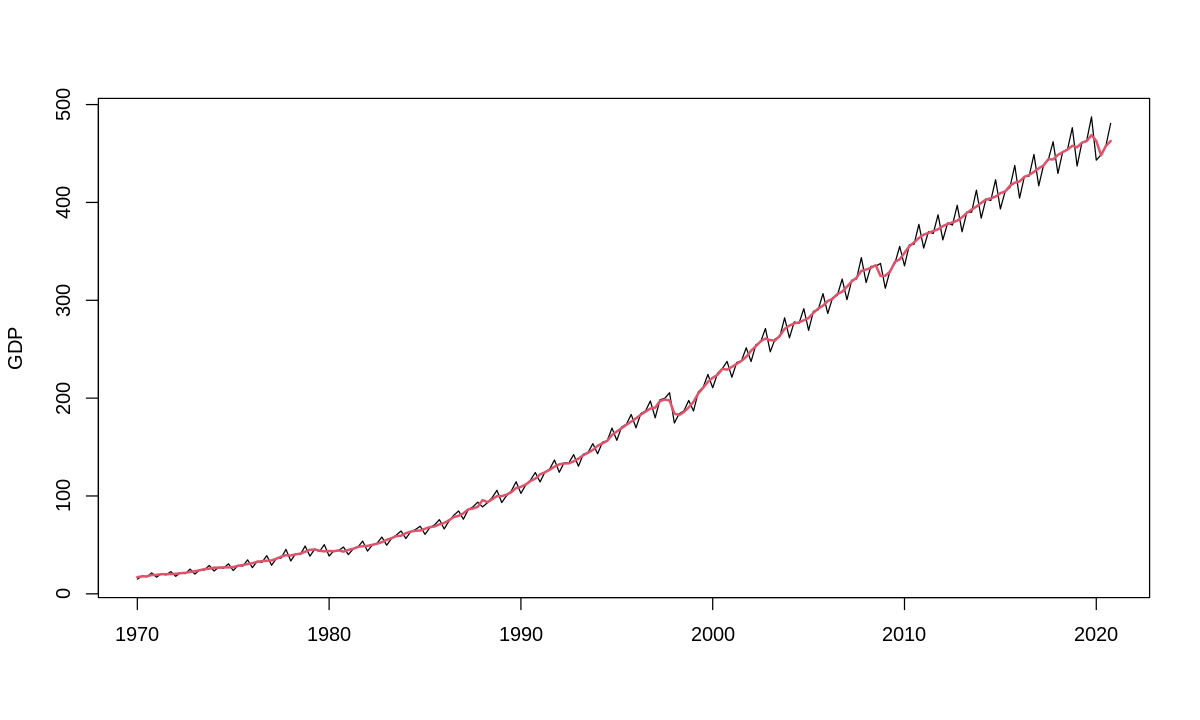

In [36]:
plot(gdp, xlab="", ylab="GDP" )
 lines(gdp_sa, col=2, lwd=2 )

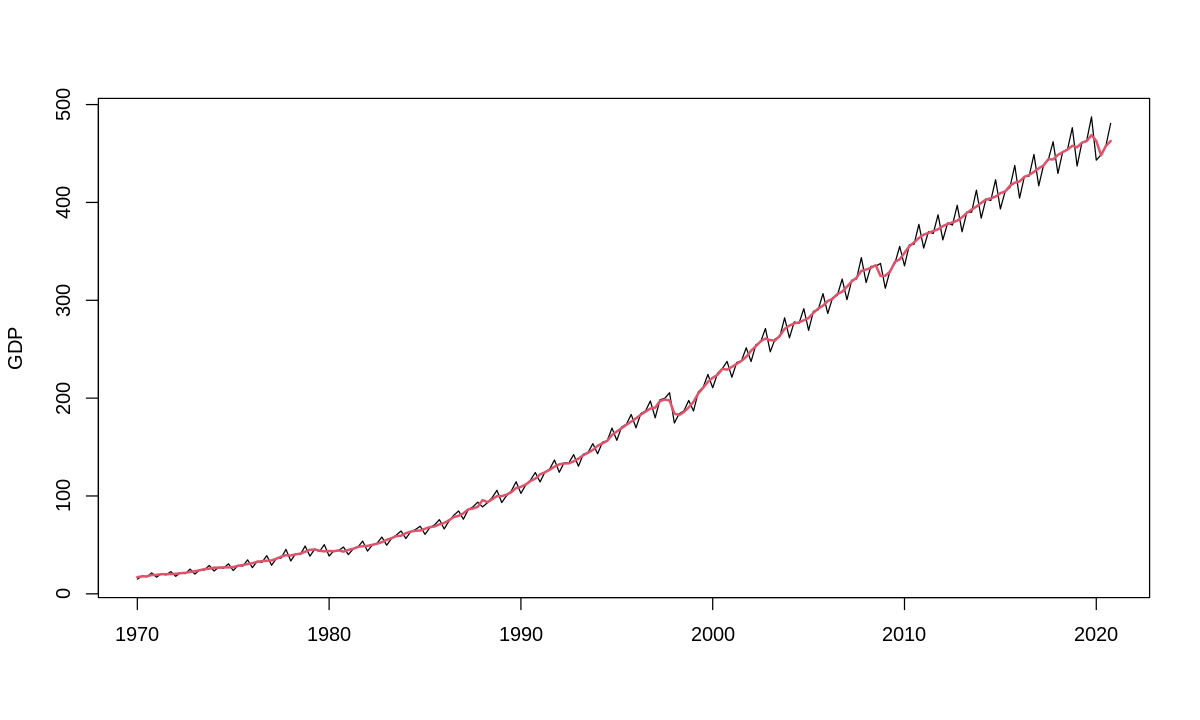

In [37]:
gdp %>% plot(xlab="", ylab="GDP" )
  gdp_sa %>% lines(col=2, lwd=2 )

## 2. forecast 패키지 데이터 불러오기
 * 예측관련 패키지
 * 시간이 좀 걸립니다.

In [5]:
install.packages('forecast')
library(forecast)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



## 3. 스펙트럼 구하기

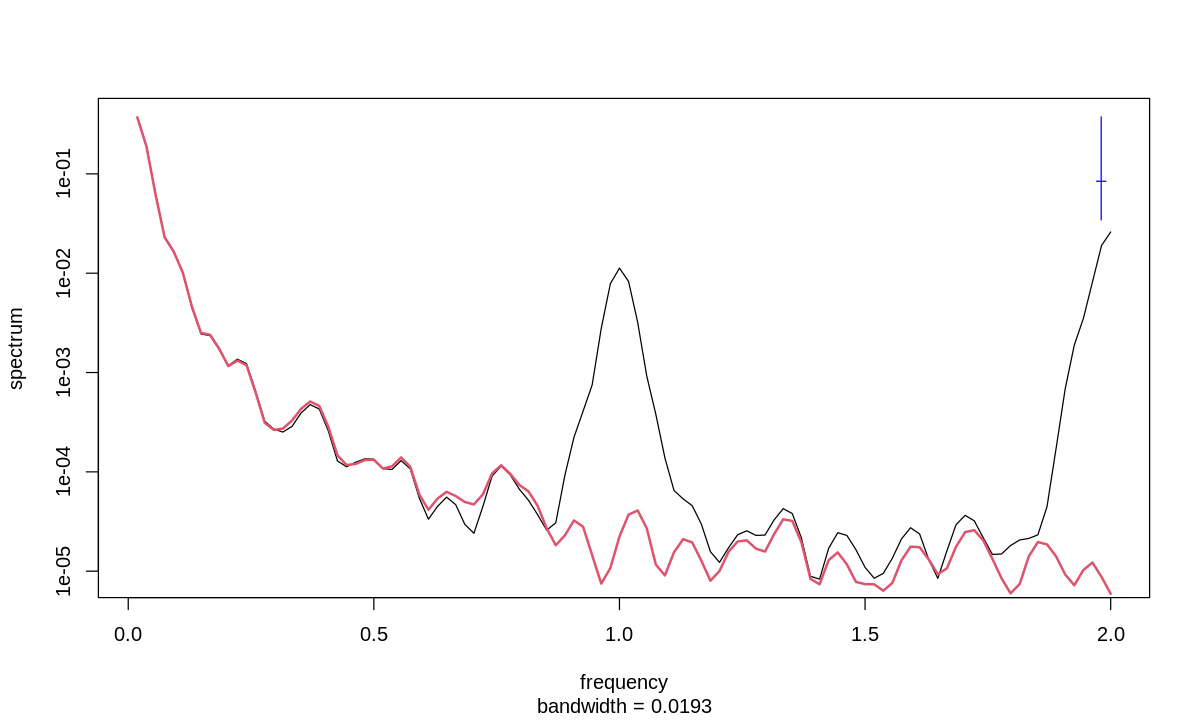

In [38]:
gdp %>% log() %>% spectrum(spans=c(3,3), main="") 
gdp_sa %>% log() %>% spectrum(spans=c(3,3), add=TRUE, col=2, lwd=2) 

## 4. 시계열의 탐색

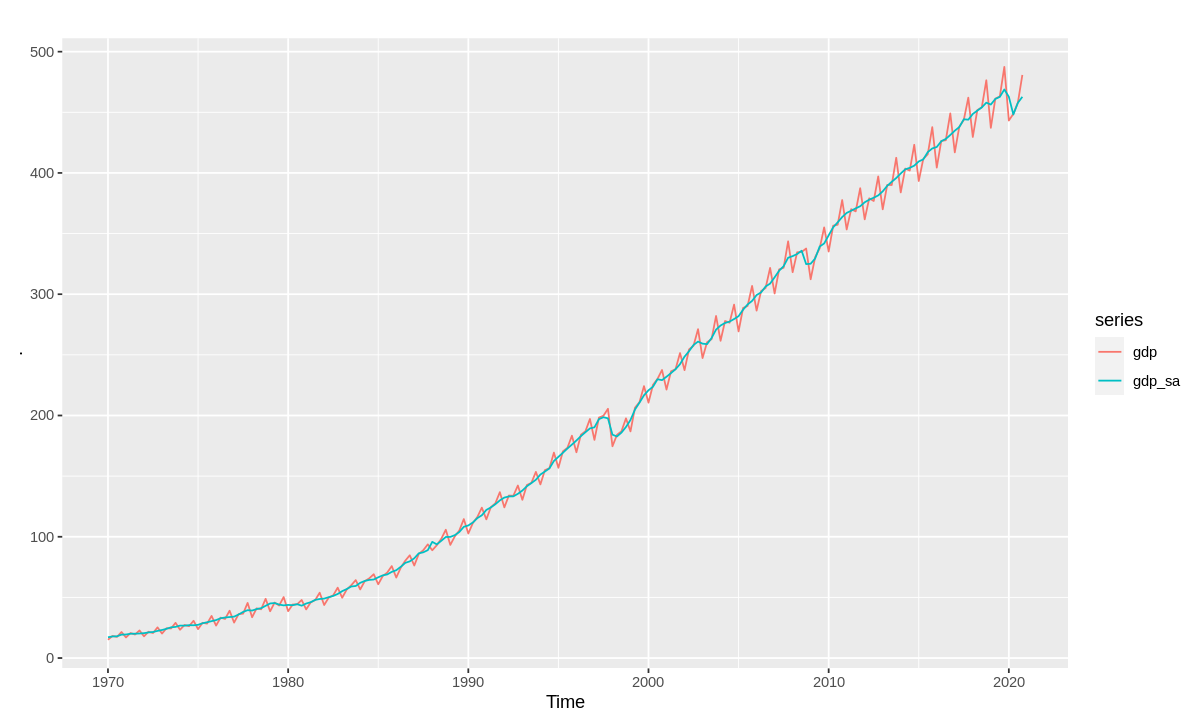

In [39]:
cbind(gdp, gdp_sa) %>% autoplot()

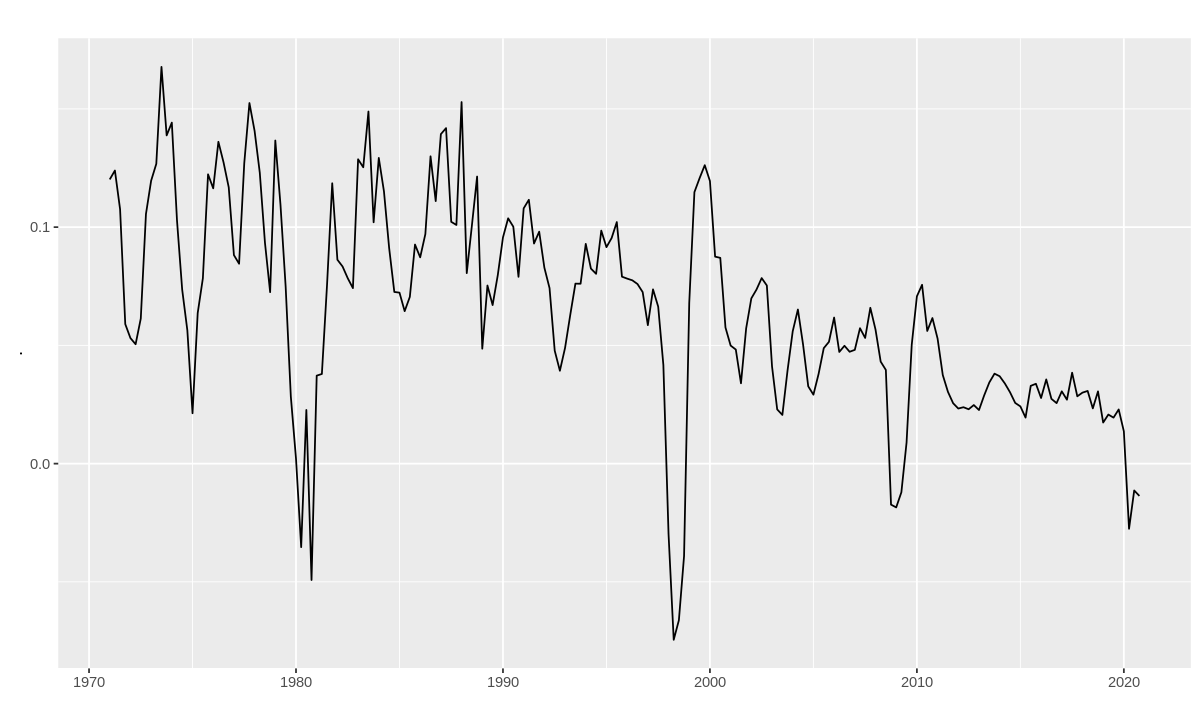

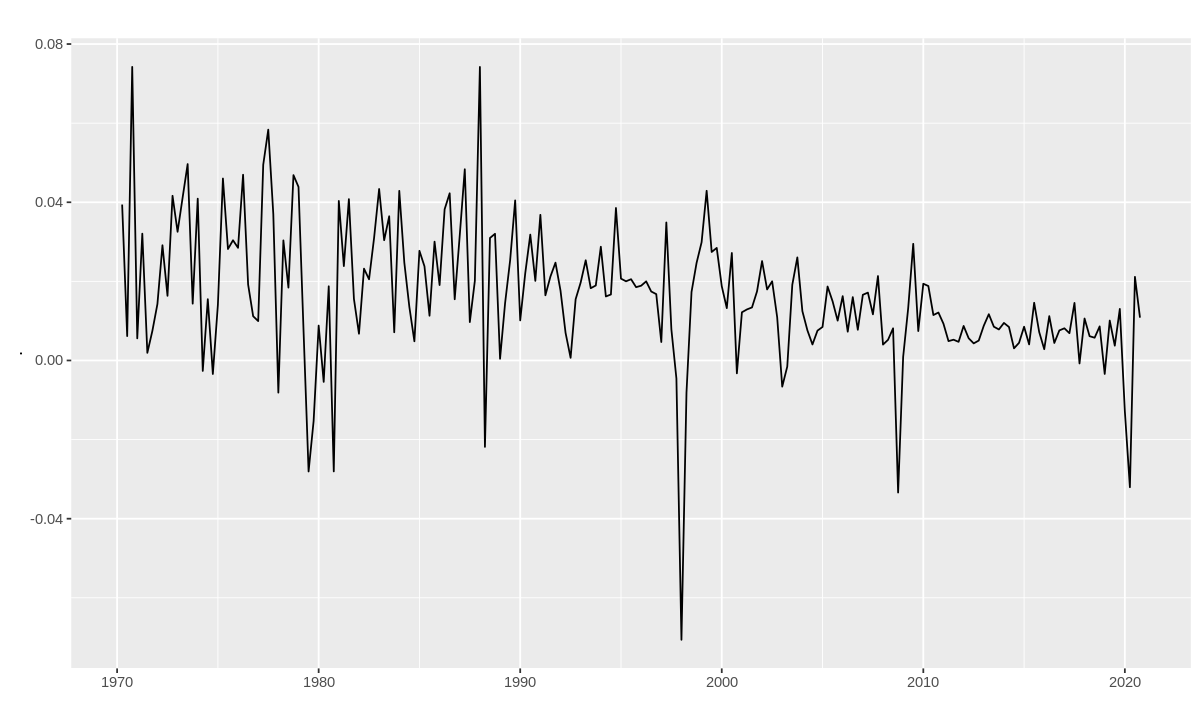

In [40]:
gdp %>% log() %>% diff(lag=4) %>% autoplot(xlab="")
gdp_sa %>% log() %>% diff() %>% autoplot(xlab="")

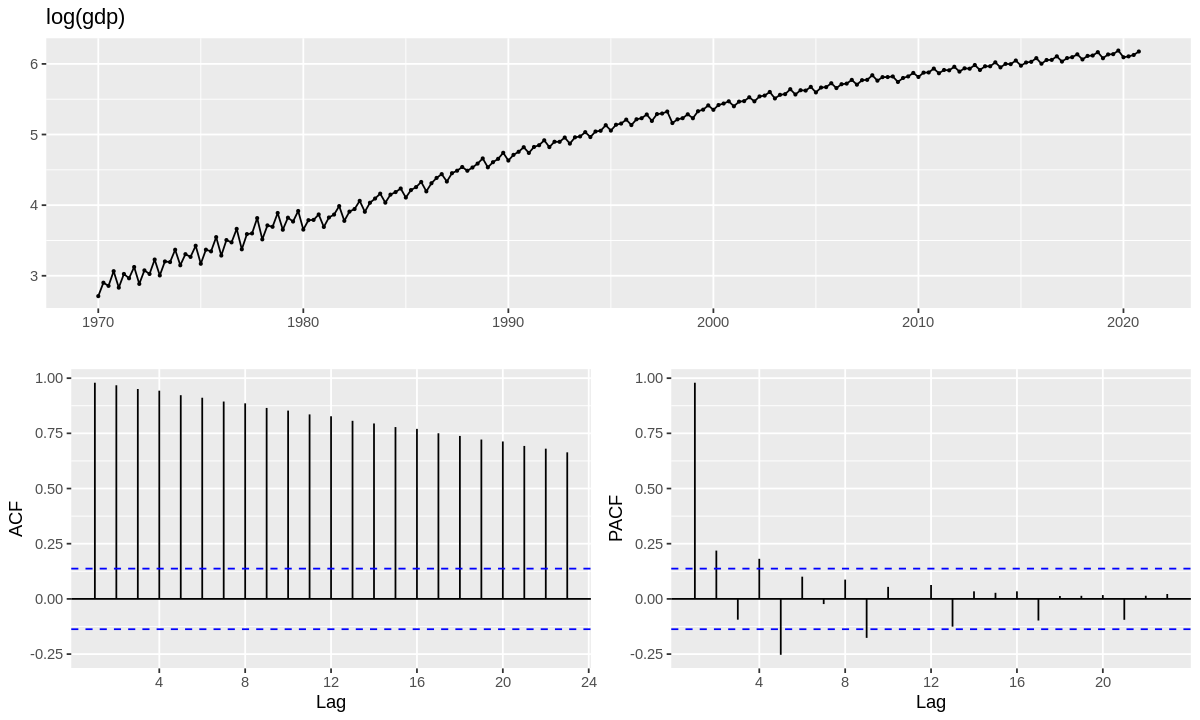

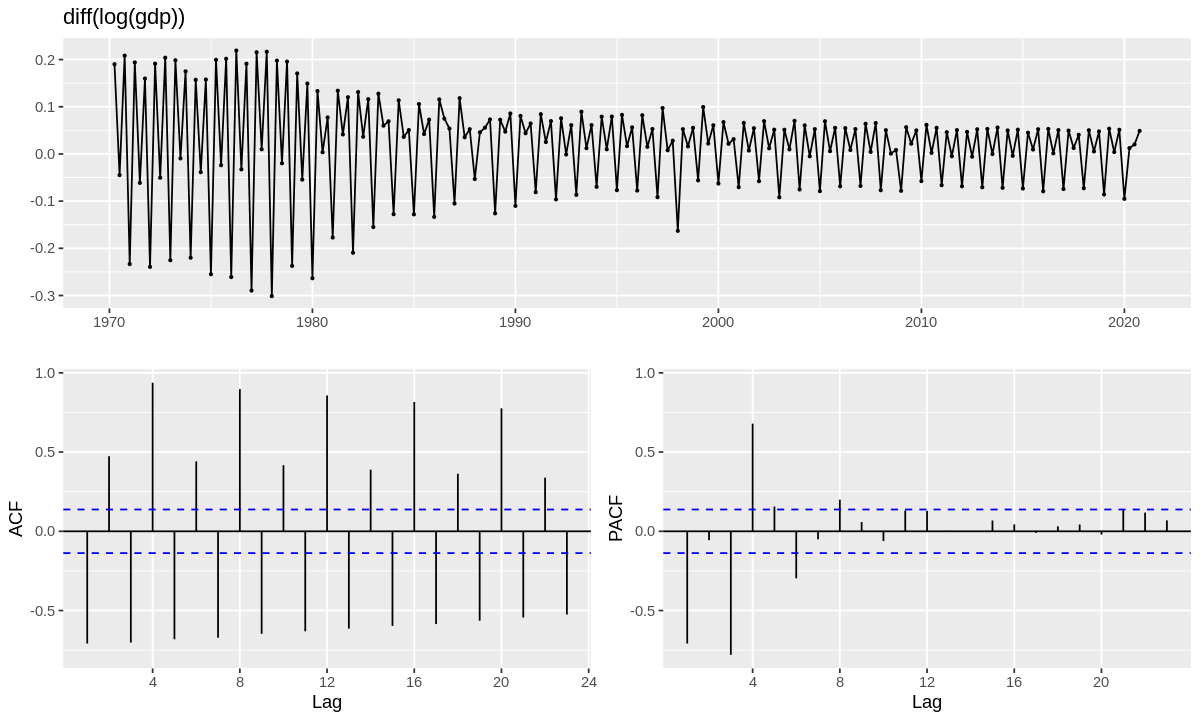

In [49]:
gdp %>% log() %>% ggtsdisplay(main="log(gdp)")
gdp %>% log() %>% diff() %>% ggtsdisplay(main="diff(log(gdp))") 

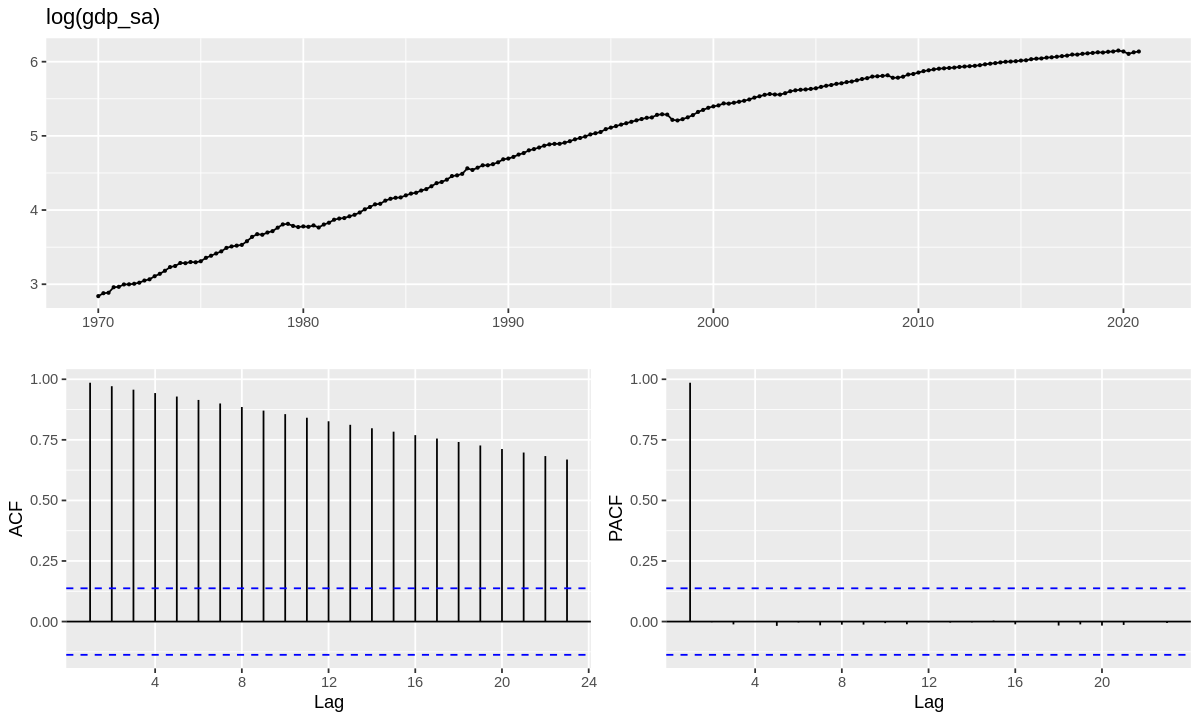

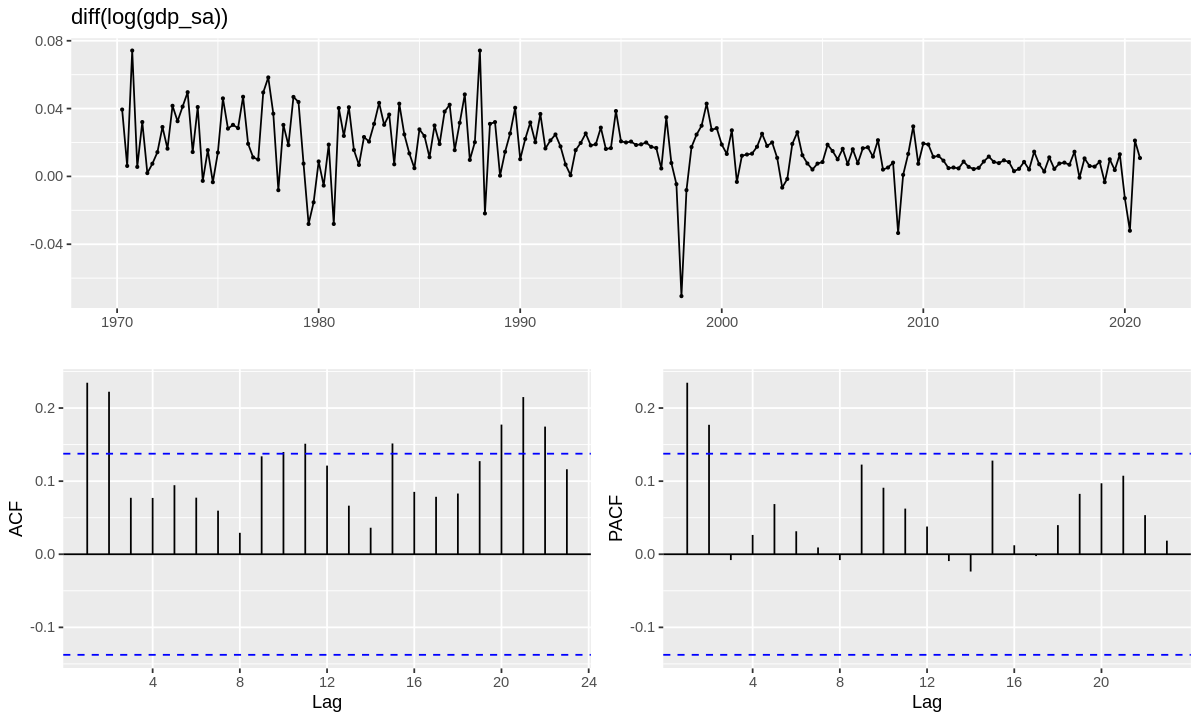

In [50]:
gdp_sa %>% log() %>% ggtsdisplay(main="log(gdp_sa)")
gdp_sa %>% log() %>% diff() %>% ggtsdisplay(main="diff(log(gdp_sa))")

## 5. ARIMA모형

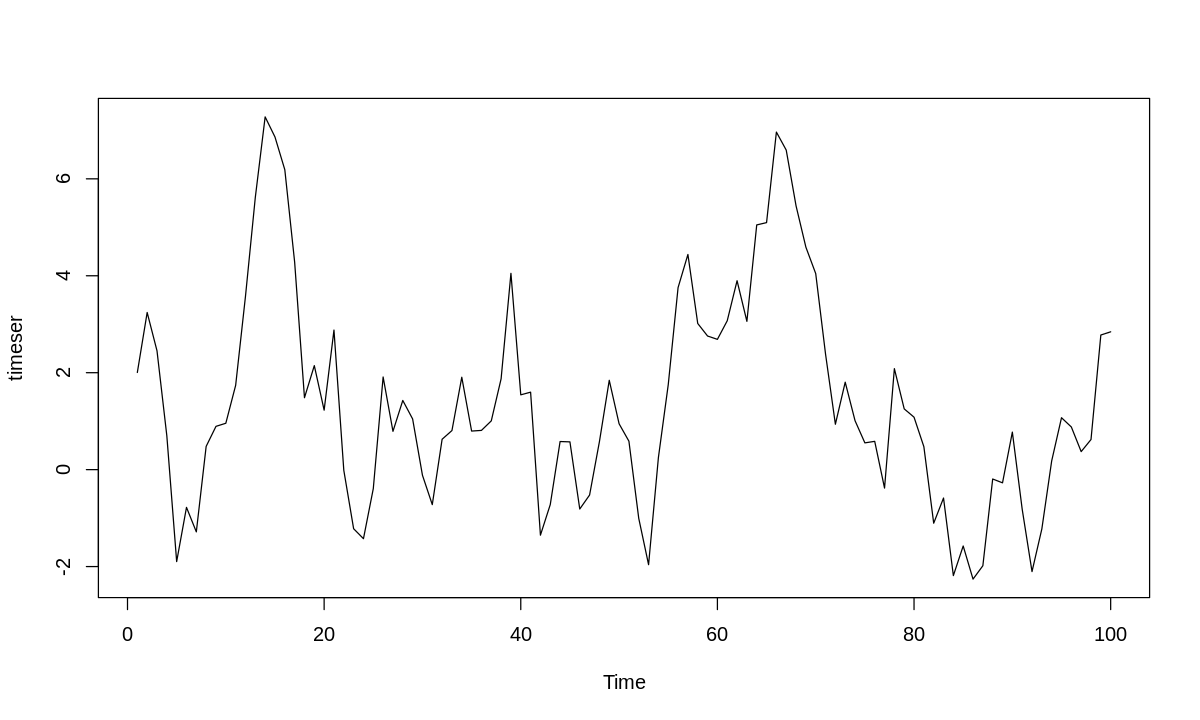

Series: . 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1     ma1     ma2    mean
      0.5532  0.4155  0.6142  1.3970
s.e.  0.0984  0.0832  0.1087  0.4965

sigma^2 estimated as 1.295:  log likelihood=-153.82
AIC=317.64   AICc=318.28   BIC=330.67

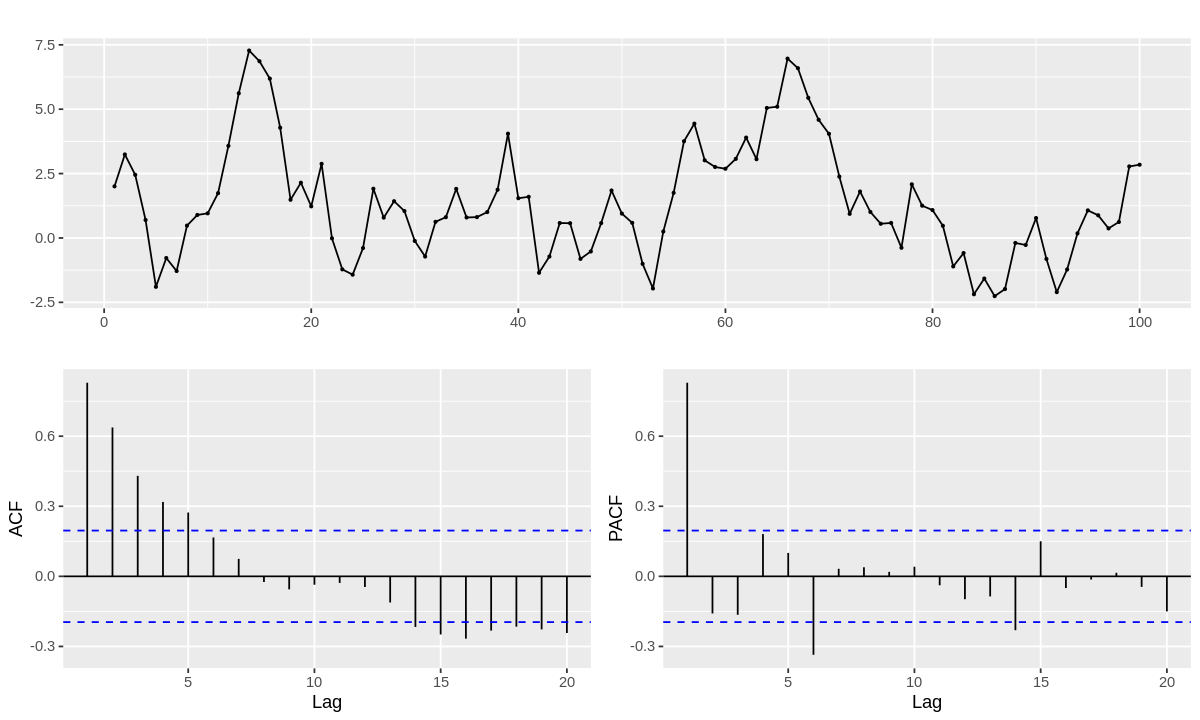

In [ ]:
set.seed(12345)
timeser=arima.sim(list(order = c(1,0,2), ma=c(0.3,0.5), ar=0.7), n = 100)
plot(timeser)
timeser %>% ggtsdisplay(main="")
timeser %>% auto.arima()

## 6. 경제성장률의 ARIMA 모형 예측

Series: . 
ARIMA(1,1,3) 

Coefficients:
          ar1      ma1      ma2      ma3
      -0.2215  -0.6234  -0.1710  -0.1441
s.e.   0.4496   0.4419   0.3964   0.0771

sigma^2 estimated as 0.0002664:  log likelihood=545.59
AIC=-1081.19   AICc=-1080.88   BIC=-1064.65

Training set error measures:
                       ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.001955502 0.01611854 0.01097297 -39.81539 150.2222 0.6860575
                    ACF1
Training set -0.01577855

	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)
Q* = 5.8426, df = 4, p-value = 0.2112

Model df: 4.   Total lags used: 8



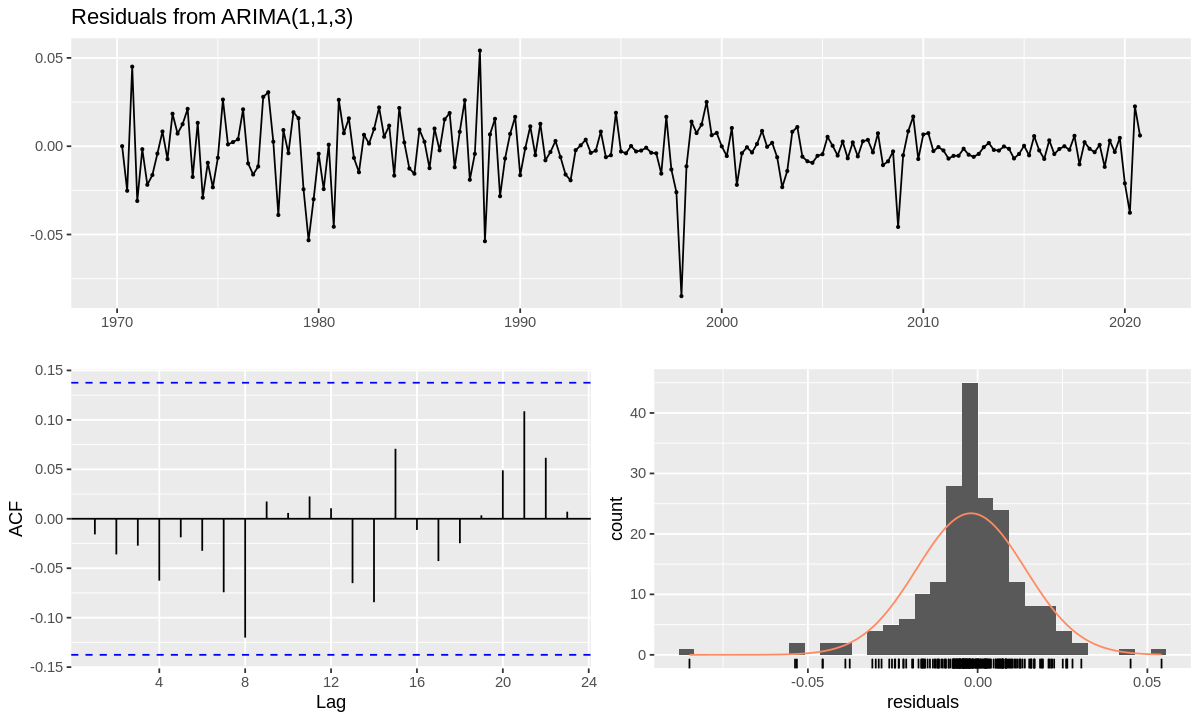

In [45]:
# ARIMA model
arima_model = auto.arima(diff(log(gdp_sa_ts[,3])))

arima_model = gdp_sa_ts[,3] %>% log() %>% diff() %>% auto.arima()
summary(arima_model)
checkresiduals(arima_model)

,Qtr1,Qtr2,Qtr3,Qtr4
2021,0.010917529,0.006615572,0.006697264,0.006679172


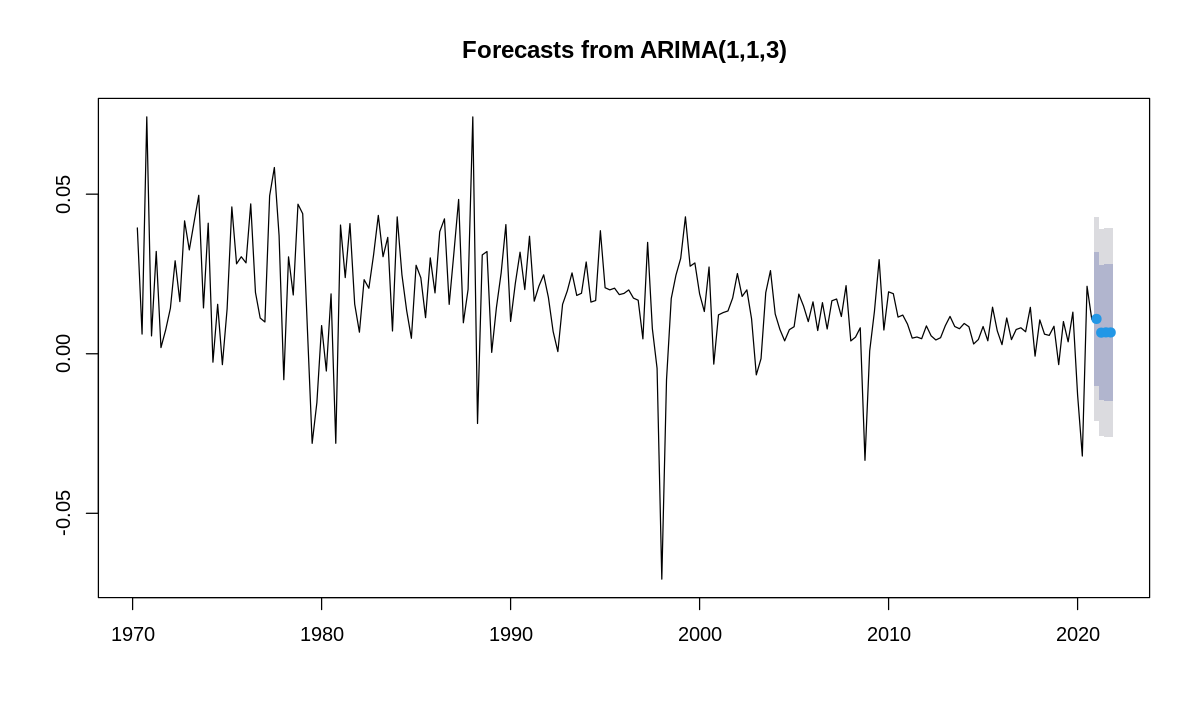

In [48]:
ff = forecast(arima_model, h=4) %>% plot()
ff$mean %>% tail()

## 7. GDP의 분해

In [71]:
install.packages("mFilter")
library(mFilter)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



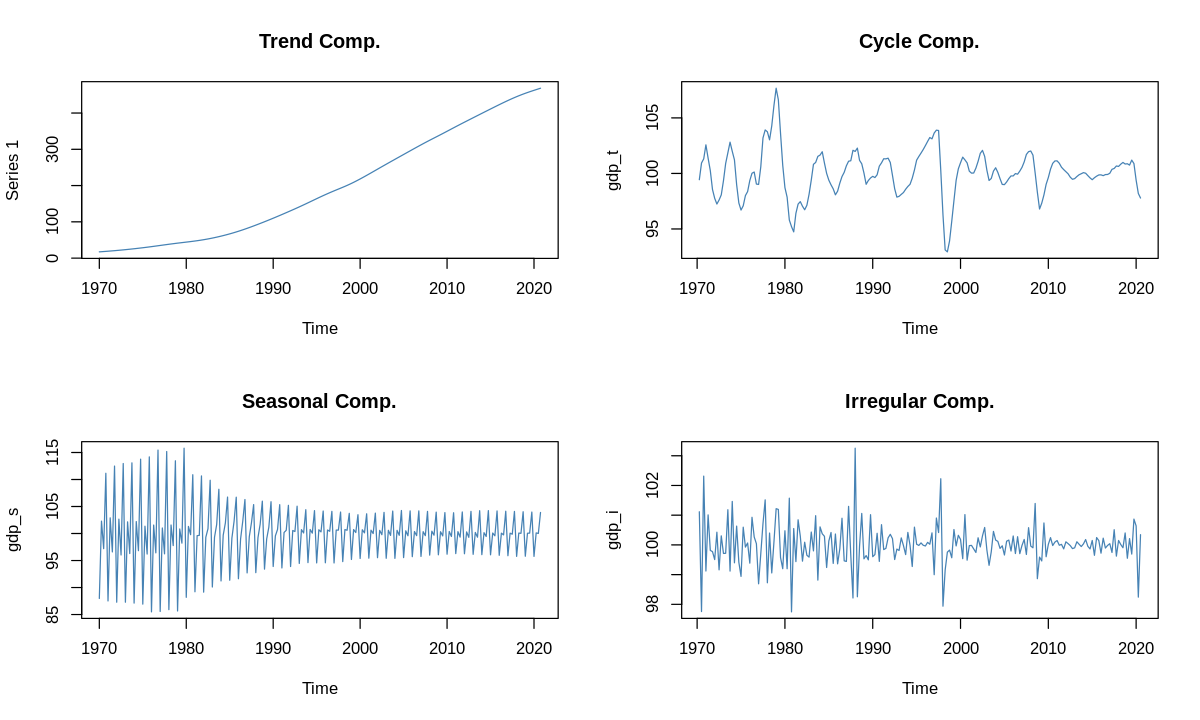

In [74]:
# GDP 변동요인 분해 
 lgdp.hp = mFilter(log(gdp_sa),filter="HP")   # Hodrick-Prescott filter
 gdp_t = exp(lgdp.hp$trend)
 gdpsam = exp((log(gdp_sa)+lag(log(gdp_sa),-1)+lag(log(gdp_sa),1))/3)
 gdp_s = gdp/gdp_sa*100
 gdp_i = gdp_sa/gdpsam*100
 gdp_c = gdpsam/gdp_t*100

 
## Fig 5-2 ##
par(mfrow=c(2,2))
plot(gdp_t, main="Trend Comp.", col="steelblue")
plot(gdp_c, main="Cycle Comp.", col="steelblue")
plot(gdp_s, main="Seasonal Comp.", col="steelblue")
plot(gdp_i, main="Irregular Comp.", col="steelblue")